# Assignment4

네번째 과제: 'Multi-layer Perceptron (MLP)'
## Packages
- [numpy](www.numpy.org)는 Python에서 행렬 작업을 위한 기본 패키지입니다.
- [matplotlib](http://matplotlib.org)는 Python에서 그래프를 그리는 라이브러리입니다.
- [scikit-learn](https://scikit-learn.org/stable/)는 Python기반 머신러닝 분석을 위한 라이브러리입니다.
- [pytorch](https://pytorch.org)는 신경망 구축에 사용되는 오픈소스 딥러닝 프레임워크입니다.
- [tabulate](https://pypi.org/project/tabulate/)는 Python에서 데이터를 테이블 형식으로 출력해주는 라이브러리입니다.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mplcolors
import sklearn.datasets as skdatasets
from sklearn.model_selection import train_test_split

##### Logistic regression

In [26]:
def generate_spiral_data(n_points, n_features, n_classes):
    np.random.seed(444)
    X = np.zeros((n_points*n_classes, n_features))
    y = np.zeros((n_points*n_classes,), dtype=np.uint8)
    for j in range(n_classes):
        i = range(n_points*j, n_points*(j+1))
        r = np.linspace(0., 1, n_points) # radius
        t = np.linspace(j*4, (j+1)*4, n_points) + np.random.randn(n_points) * 0.2 # theta
        X[i] = np.c_[r*np.sin(t), r*np.cos(t)]
        y[i] = j
    return train_test_split(X, y, test_size=0.2, random_state=444)

def plot_spiral(X, y, x1_mesh=None, x2_mesh=None, x3_mesh=None):
    x1, x2 = X[:, 0], X[:, 1]
    plt.figure(figsize=(10, 6))
    plt.scatter(x1[y==0], x2[y==0], c='tab:blue', marker='o', label='class:0')
    plt.scatter(x1[y==1], x2[y==1], c='tab:orange', marker='^', label='class:1')
    plt.scatter(x1[y==2], x2[y==2], c='tab:green', marker='x', label='class:2')
    if x1_mesh is not None:
        cmap = mplcolors.ListedColormap(['tab:blue', 'tab:orange', 'tab:green'])
        plt.contourf(x1_mesh, x2_mesh, y_mesh, levels=3, cmap=cmap, alpha=0.3)
    plt.title('MLP (Spiral dataset)', fontsize=18, pad=12)
    plt.xlabel('x1', fontsize=16, labelpad=12)
    plt.ylabel('x2', fontsize=16, labelpad=12)
    plt.legend(fontsize=14, loc='upper left')
    plt.show()

In [27]:
x_train, x_test, y_train, y_test = generate_spiral_data(n_points=100, n_features=2, n_classes=3)

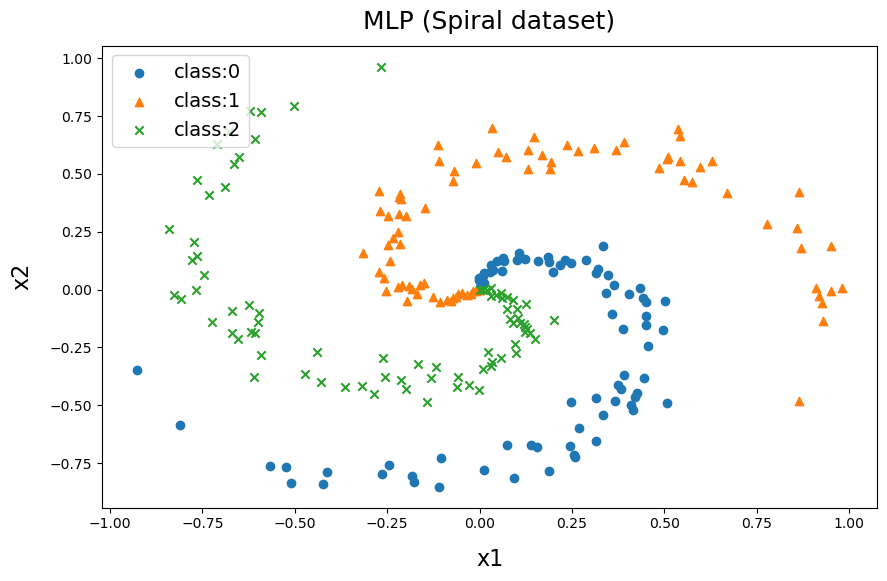

In [28]:
plot_spiral(x_train, y_train)

#### Train on lineary non-separable dataset!

### MLP implementation

In [61]:
def softmax(x):
    yhat = None
    #########################################################################
    # TODO: Implement the softmax function without using explicit loops.    #
    # Store the softmax scores in the yhat variable.                        #
    #########################################################################
    # ******** START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE) ******** #

    yhat = np.exp(x) / np.sum(np.exp(x), axis=1, keepdims=True)

    # ********* END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE) ********* #
    return yhat

def one_hot(x, n_class):
	return np.eye(n_class)[x]

def cross_entropy_loss(yhat, y, n_class):
    # clip values to prevent divide by zero
    yhat = np.clip(yhat, a_min=1e-7, a_max=1-1e-7)

    loss = None
    #########################################################################
    # TODO: Implement the cross-entropy function. Store the cross-entropy   #
    # loss in the loss variable. Note that the yhat is the output of the    #
    # softmax function implemented above.                                   #
    #########################################################################
    # ******** START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE) ******** #
    # print(n_class, y.shape, yhat.shape)
    if y.ndim == 1:
         y = one_hot(y, n_class)
    loss = -np.sum(y *np.log(yhat))

    # ********* END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE) ********* #
    
    return loss

In [41]:
class Linear:
    def __init__(self, in_features, out_features, is_first=False):
        #########################################################################
        # TODO: Initialize the weights and biases of the linear layer. Store    #
        # the weights in the self.w variable and biases in the self.b variable. #
        # Weights should be a 2d np.ndarray of shape (in_features, out_features)#
        # and initialized from a Uniform ranged [0, 1]. Biases should be a 1d   #
        # np.ndarray of shape (out_features,) and initialized to zero.          #
        #########################################################################
        # ******** START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE) ******** #
        
        self.w = np.random.uniform(0, 1, (in_features, out_features))
        self.b = np.zeros(out_features,)

        # ********* END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE) ********* #
        self.dw = None
        self.db = None
        self.is_first = is_first
    
    def __call__(self, x):
        out = None
        self.input = x # cache for backward
        #########################################################################
        # TODO: Implement the forward pass for the linear layer. Compute the    #
        # affine transform of X and store the result in the out variable.       #
        #########################################################################
        # ******** START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE) ******** #
        
        out = np.dot(self.input, self.w) + self.b

        # ********* END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE) ********* #
        return out
    
    def backward(self, dout):
        #########################################################################
        # TODO: Implement the backward pass for the linear layer. Store the     #
        # gradient of loss w.r.t weights (dL/dw) in the self.dw variable, and   #
        # the gradient of loss w.r.t biases (dL/db) in the self.db variable.    #
        #########################################################################
        # ******** START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE) ******** #
        
        self.dw = np.dot(self.input.T, dout)
        self.db = np.sum(dout, axis=0)

        # ********* END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE) ********* #

        dx = None
        #########################################################################
        # TODO: Implement the backward pass for the linear layer. Store the     #
        # gradient of loss w.r.t inputs (dL/dx) in the dx variable. Note that   #
        # we compute dx, if this is not the first layer (i.e., if self.is_first #
        # is False)                                                             #
        #########################################################################
        # ******** START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE) ******** #

        if not self.is_first:
            dx = np.dot(dout, self.w.T)
        else:
            dx = dout
        
        # ********* END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE) ********* #

        return dx

In [32]:
class ReLU:
    def __call__(self, x):
        self.input = x # cache for backward

        out = None
        #########################################################################
        # TODO: Implement the forward pass of ReLU layer. Store the computed    #
        # values in the out variable                                            #
        #########################################################################
        # ******** START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE) ******** #

        out = np.maximum(0, self.input)

        # ********* END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE) ********* #
        return out
    
    def backward(self, dout):
        dx = None
        #########################################################################
        # TODO: Implement the backward pass of ReLU layer. Store the computed   #
        # values in the dx variable. Note that you can use self.input to        #
        # compute the gradients.                                                #
        #########################################################################
        # ******** START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE) ******** #

        dx = dout * (self.input > 0)

        # ********* END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE) ********* #
        return dx

In [33]:
class MLP:
    def __init__(self, features):
        def setup_layers(features):
            layers = [] # n: in_features, m: out_features
            for i, (n, m) in enumerate(zip(features[:-1], features[1:])):
                layers += [Linear(n, m, i==0), ReLU()]
            del layers[-1]
            return layers
        
        self.layers = setup_layers(features)
    
    def __call__(self, X):
        for layer in self.layers:
            X = layer(X)
        return X
    
    def backward(self, dout):
        for layer in reversed(self.layers):
            dout = layer.backward(dout)

In [43]:
class CrossEntropyLoss:
    def __init__(self, n_class):
        self.n_class = n_class
    
    def __call__(self, x, y):
        loss, grad = None, None
        #########################################################################
        # TODO: Compute the cross-entropy loss and its gradient without using   #
        # explicit loops. Store the loss in loss variable and the gradient in   #
        # grad variable. Please use the softmax and cross_entropy_loss function #
        # implemented above.                                                    #
        #########################################################################
        # ******** START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE) ******** #

        y_onehot = one_hot(y, self.n_class)
        yhat = softmax(x)
        loss = cross_entropy_loss(yhat, y_onehot, self.n_class)
        grad = yhat - y_onehot

        # ********* END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE) ********* #
        return loss, grad

In [35]:
class GradientDescent:
    def __init__(self, layers, lr):
        self.layers = layers
        self.lr = lr

    def step(self):
        #########################################################################
        # TODO: Implement the gradient descent algorithm. Note that self.layers #
        # is a list of layers, where each of them could be either Linear or     # 
        # ReLU. Since a ReLU layer doesn't have learnable parameters, we only   #
        # update the parameters of the Linear layers. Loop through self.layers  #
        # and update the parameters if the layer is instance of Linear class.   #
        #########################################################################
        # ******** START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE) ******** #

        for layer in self.layers:
            if isinstance(layer, Linear):
                layer.w -= self.lr * layer.dw
                layer.b -= self.lr * layer.db

        # ********* END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE) ********* #

In [56]:
def train_mlp(x_train, x_test, y_train, y_test, features, lr, epochs, log_every):
    # set seed
    np.random.seed(444)

    # make a single linear layer
    model = MLP(features)

    # make optimizer
    optim = GradientDescent(model.layers, lr)

    # loss function
    n_class = len(np.unique(y_train))
    loss_fn = CrossEntropyLoss(n_class)

    # evaluation function
    eval_fn = lambda yhat, y: np.mean(np.argmax(yhat, axis=1) == y)

    # begin training
    for e in range(1, epochs+1):
        # forward (linear layer)
        out = model(x_train)
        # compute cross-entropy loss and gradient w.r.t out
        loss, dout = loss_fn(out, y_train)
        # backward (linear layer)
        model.backward(dout)
        # gradient descent
        optim.step()
        # print log
        if e % log_every == 0:
            yhat = softmax(model(x_test))
            loss = cross_entropy_loss(yhat, y_test, n_class)
            accr = eval_fn(yhat, y_test)
            print(f'Epochs: {e}/{epochs}, loss (test): {loss:.4f}, accuracy (test): {accr:.4f}')
    
    return model

def compute_decision_boundary_mlp(x, model, resolution):
    x1, x2 = x[:, 0], x[:, 1]
    x1_mesh = np.linspace(np.min(x1) - 0.1, np.max(x1) + 0.1, resolution)
    x2_mesh = np.linspace(np.min(x2) - 0.1, np.max(x2) + 0.1, resolution)
    x1_mesh, x2_mesh = np.meshgrid(x1_mesh, x2_mesh, indexing='xy')
    x = np.c_[x1_mesh.ravel(), x2_mesh.ravel()]
    y_mesh = np.argmax(softmax(model(x)), axis=1).reshape(resolution, resolution)
    return x1_mesh, x2_mesh, y_mesh

In [62]:
slp = train_mlp(x_train, x_test, y_train, y_test, features=[2, 3], lr=1e-2, epochs=200, log_every=20)

Epochs: 20/200, loss (test): 47.4197, accuracy (test): 0.5500
Epochs: 40/200, loss (test): 46.6134, accuracy (test): 0.5500
Epochs: 60/200, loss (test): 46.5389, accuracy (test): 0.5500
Epochs: 80/200, loss (test): 46.5493, accuracy (test): 0.5500
Epochs: 100/200, loss (test): 46.5662, accuracy (test): 0.5500
Epochs: 120/200, loss (test): 46.5785, accuracy (test): 0.5500
Epochs: 140/200, loss (test): 46.5862, accuracy (test): 0.5500
Epochs: 160/200, loss (test): 46.5908, accuracy (test): 0.5500
Epochs: 180/200, loss (test): 46.5935, accuracy (test): 0.5500
Epochs: 200/200, loss (test): 46.5950, accuracy (test): 0.5500


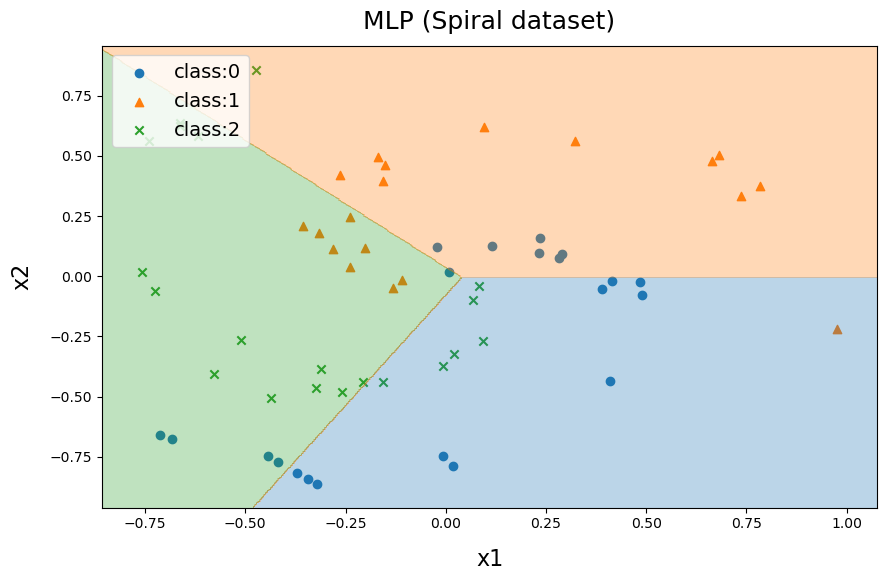

In [63]:
x1_mesh, x2_mesh, y_mesh = compute_decision_boundary_mlp(x_test, slp, resolution=500)
plot_spiral(x_test, y_test, x1_mesh, x2_mesh, y_mesh)

In [64]:
mlp = train_mlp(x_train, x_test, y_train, y_test, features=[2, 10, 3], lr=1e-2, epochs=500, log_every=50)

Epochs: 50/500, loss (test): 39.4513, accuracy (test): 0.6833
Epochs: 100/500, loss (test): 44.3464, accuracy (test): 0.6500
Epochs: 150/500, loss (test): 37.7654, accuracy (test): 0.7167
Epochs: 200/500, loss (test): 11.8135, accuracy (test): 0.9333
Epochs: 250/500, loss (test): 9.2774, accuracy (test): 0.9500
Epochs: 300/500, loss (test): 5.6188, accuracy (test): 0.9833
Epochs: 350/500, loss (test): 6.4272, accuracy (test): 0.9667
Epochs: 400/500, loss (test): 5.2851, accuracy (test): 0.9667
Epochs: 450/500, loss (test): 5.5514, accuracy (test): 0.9667
Epochs: 500/500, loss (test): 3.3271, accuracy (test): 1.0000


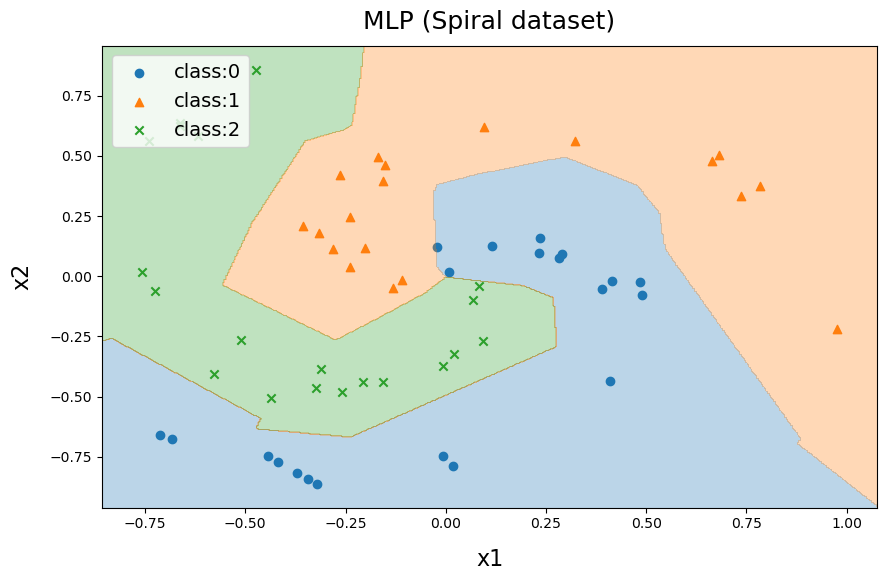

In [65]:
x1_mesh, x2_mesh, y_mesh = compute_decision_boundary_mlp(x_test, mlp, resolution=500)
plot_spiral(x_test, y_test, x1_mesh, x2_mesh, y_mesh)

### CNN

In [66]:
import numpy as np
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import matplotlib.colors as mplcolors
from tqdm import tqdm
from torch.utils.data import DataLoader
from tabulate import tabulate

ModuleNotFoundError: No module named 'torch'

In [ ]:
def load_mnist(data_dir, train, download, transform):

    data = torchvision.datasets.MNIST(data_dir, train, download=True, transform=transform)

    return data

### PLZ change the directory below

In [ ]:
transform = transforms.Compose([transforms.ToTensor()])
# 'data_dir' argument: path to your directory where the MNIST dataset to be downloaded
train_data = load_mnist(data_dir='/path/to/your/dir', train=True, download=True, transform=transform)
test_data = load_mnist(data_dir='/path/to/your/dir', train=False, download=True, transform=transform)

In [ ]:
def print_data_stats(data):

    number_of_images = len(data)

    img_size = 'x'.join(map(str, data.data.shape[1:]))

    avg_data = data.data.float().mean()
    std_data = data.data.float().std()
    ms_data = f'{avg_data:.2f} ({std_data:.2f})'

    n_class_data, n_img_class_data = np.unique(data.targets, return_counts=True)
    n_class_data = len(n_class_data)
    n_img_class_data = ', '.join([f'{i}: {n:4d}' for i, n in enumerate(n_img_class_data)])

    data_stats = [[number_of_images, img_size, ms_data, n_img_class_data]]
    print(tabulate(data_stats, headers=['n img', 'img size', 'mean & stdv', 'n img per class' ]))

In [ ]:
print_data_stats(train_data)

  n img  img size    mean & stdv    n img per class
-------  ----------  -------------  ----------------------------------------------------------------------------------------
  60000  28x28       33.32 (78.57)  0: 5923, 1: 6742, 2: 5958, 3: 6131, 4: 5842, 5: 5421, 6: 5918, 7: 6265, 8: 5851, 9: 5949


In [ ]:
def random_indices(n_class, labels):
    indices = []
    for i in range(n_class):
        idx = np.where(labels == i)[0]
        idx_selected = np.random.choice(idx, size=3)
        indices.append(idx_selected)
    return np.array(indices).T

def plot_random_images(images, labels, n_class):
    indices = random_indices(n_class, np.array(labels))
    nrow, ncol = indices.shape

    fig, axs = plt.subplots(nrow, ncol, figsize=(15,5), constrained_layout=True)
    for i in range(nrow):
      for j in range(ncol):
        img = images[indices[i][j]]
        axs[i][j].imshow(img, cmap='gray')
        axs[i][j].set_xticks([])
        axs[i][j].set_yticks([])

In [ ]:
plot_random_images(train_data.data, train_data.targets, n_class=10)

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        #########################################################################################
        # TODO: Implement __init__() function. Create a convolutional neural net using pytorch  #
        # nn.Module. The CNN architecture is as follows:                                        #
        #     [Layer1] -> Conv layer (in_channels=1, out_channels=6, kernel=5, stride=1)        #
        #     [Layer2] -> ReLU layer                                                            #
        #     [Layer3] -> MaxPool layer (kernel=2, stride=2)                                    #
        #     [Layer4] -> Conv layer (in_channels=6, out_channels=16, kernel=2, stride=1)       #
        #     [Layer5] -> ReLU layer                                                            #
        #     [Layer6] -> MaxPool layer (kernel=2, stride=2)                                    #
        #     [Layer7] -> Flatten layer                                                         #
        #     [Layer8] -> Linear layer (in_features=400, out_features=120)                      #
        #     [Layer9] -> ReLU layer                                                            #
        #     [Layer10] -> Linear layer (in_features=120, out_features=84)                      #
        #     [Layer11] -> ReLU layer                                                           #
        #     [Layer12] -> Linear layer (in_features=84, out_features=10)                       #
        #########################################################################################
        # **************** START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE) **************** #

        
        # ***************** END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE) ***************** #
    
    def forward(self, x):
        return self.net(x)

In [ ]:
def train(train_data, test_data, epochs, batch_size, lr):
    # set seed
    torch.manual_seed(0)

    # set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    #################################################################################
    # TODO: Implement a training function. You MUST implement all of the following: #
    #       (1) Load dataset (both train and test data) into pytorch DataLoader.    #
    #           Set shuffle argument True for train data and False for test data.   #
    #       (2) Instantiate a CNN model and ship to a device.                       #
    #           Please use the device variable above.                               #
    #       (3) Instantiate a sgd optimizer.                                        #
    #       (4) Instantiate a cross-entropy loss function.                          #
    #       (5) Implement one_step function (see the function below for details).   #
    #################################################################################
    # ************ START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE) ************ #

    # TODO: (1) load dataset into dataloader


    # TODO: (2) instantiate a CNN model and ship to device


    # TODO: (3) instantiate a sgd optimizer


    # TODO: (4) instantiate a cross-entropy loss function


    # eval function
    def calc_accuracy(yhat, y):
        labels = torch.argmax(yhat, dim=1)
        return (labels == y).sum().item() / y.size(0)

    eval_fn = calc_accuracy

    # lists to store training logs
    train_losses, train_accrs = [], []
    test_losses, test_accrs = [], []

    # TODO: (5) Implement one_step function
    def one_step(x, y, is_training):
        loss, accr = None, None
        ###################################################################################
        # TODO: Implement step function. This function intakes x, y, and is_training and  #
        # returns loss and accuracy. x is the input images and y is the corresponding     #
        # class labels. is_training is a boolean argument indicating if this function is  #
        # called in the training phase or the test phase. Note that it will be used in the#
        # main training loop below. You MUST implement all of the following:              #
        #       (5.1) forward propagation.                                                #
        #       (5.2) compute cross-entropy loss and store the result in loss variable.   #
        #       (5.3) compute accuracy and store the result in accr variable.             #
        #       (5.4) set all gradient tensors to zero.                                   #
        #       (5.5) compute the gradient of all leaf tensors (back propagation).        #
        #       (5.6) update the parameters using the SGD algorithm.                      #
        ###################################################################################
        # ************* START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE) ************* #
        
        # TODO: (5.1) forward propagation


        # TODO: (5.2) compute cross-entropy loss


        # TODO: (5.3) compute accuracy


        if is_training:
            # TODO: (5.4) set gradient zero


            # TODO: (5.5) compute gradients


            # TODO: (5.6) update parameters


        # ************** END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE) ************** #
        return loss, accr
    

    # main training loop
    for e in range(epochs):
        train_loss = 0.
        train_accr = 0.
        for i, (x, y) in enumerate(tqdm(train_loader)):
            # ship data to device
            x = x.to(device)
            y = y.to(device)
            # NOTE: here we call the step function
            loss, accr = one_step(x, y, is_training=True)
            # accumulate the loss and accuracy
            train_loss += loss
            train_accr += accr
        # save log
        train_losses.append(train_loss.item()/(i+1))
        train_accrs.append(train_accr/(i+1))

        # validation
        with torch.no_grad():
            test_loss = 0.
            test_accr = 0.
            for i, (x, y) in enumerate(tqdm(test_loader)):
                # ship data to device
                x = x.to(device)
                y = y.to(device)
                loss, accr = one_step(x, y, is_training=False)
                test_loss += loss
                test_accr += accr
            # save log
            test_losses.append(test_loss.item()/(i+1))
            test_accrs.append(test_accr/(i+1))
        
        # print log
        log = f'Epoch: {e+1}/{epochs}, ' + \
              f'loss (train): {train_losses[-1]:.4f}, ' + \
              f'accuracy (train): {train_accrs[-1]*100:2.2f}%, ' + \
              f'loss (test): {test_losses[-1]:.4f}, ' + \
              f'accuracy (test): {test_accrs[-1]*100:2.2f}%'
        print(log)
    
    print('Done.')

    return train_losses, train_accrs, test_losses, test_accrs
    # ************* END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE) ************* #
            

In [ ]:
train_loss, train_accr, test_loss, test_accr = train(train_data, test_data, epochs=5, batch_size=32, lr=1e-2)